# Can We Improve Results Using Covariance Feature Selection?

In [1]:
# Necessary libraries
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Import dataset
from sklearn.datasets import fetch_kddcup99
kdd99_data = fetch_kddcup99()
import numpy as np
X = kdd99_data['data']
y = kdd99_data['target']

y[y == b'normal.'] = 1
y[y != 1] = -1
y = np.int64(y)

In [3]:
# Remove categorial columns
X_no_cat = np.delete(X,[1,2,3],1)
print(X_no_cat.shape)
print(y.shape)

(494021, 38)
(494021,)


In [34]:
# Take a random sample from 10% of data
sample_indices = np.random.choice(range(len(y)), 59000)
X_sample = X_no_cat[sample_indices,:]
y_sample = y[sample_indices]
print(X_sample.shape)
print(y_sample.shape)

(59000, 38)
(59000,)


## Using our sample, let's take a look at the covariance heat map and determine which features are strongly related. 

First, we must convert our numpy array into a pandas dataframe so that we can visualize the relationships between the features with a heatmap.

In [5]:
X_sample = pd.DataFrame({'Column1': X_sample[:, 0], 'Column2': X_sample[:, 1],'Column3': X_sample[:, 2], 'Column4': X_sample[:, 3],'Column5': X_sample[:, 4],'Column6': X_sample[:, 5],'Column7': X_sample[:, 6],'Column8': X_sample[:, 7],'Column9': X_sample[:, 8],'Column10': X_sample[:, 9],'Column11': X_sample[:, 10], 'Column12': X_sample[:, 11], 'Column13': X_sample[:, 12], 'Column14': X_sample[:, 13],'Column15': X_sample[:, 14],'Column16': X_sample[:, 15],'Column17': X_sample[:, 16],'Column18': X_sample[:, 17],'Column19': X_sample[:, 18],'Column20': X_sample[:, 19],'Column21': X_sample[:, 20],'Column22': X_sample[:, 21],'Column23': X_sample[:, 22],'Column24': X_sample[:, 23],'Column25': X_sample[:, 24],'Column26': X_sample[:, 25],'Column27': X_sample[:, 26],'Column28': X_sample[:, 27],'Column29': X_sample[:, 28],'Column30': X_sample[:, 29],'Column31': X_sample[:, 30],'Column32': X_sample[:, 31],'Column33': X_sample[:, 32],'Column34': X_sample[:, 33],'Column35': X_sample[:, 34],'Column36': X_sample[:, 35],'Column37': X_sample[:, 36],'Column38': X_sample[:, 37]})
# print(X_sample)

In [6]:
# X_sample.head()

In [7]:
# X_sample.describe()

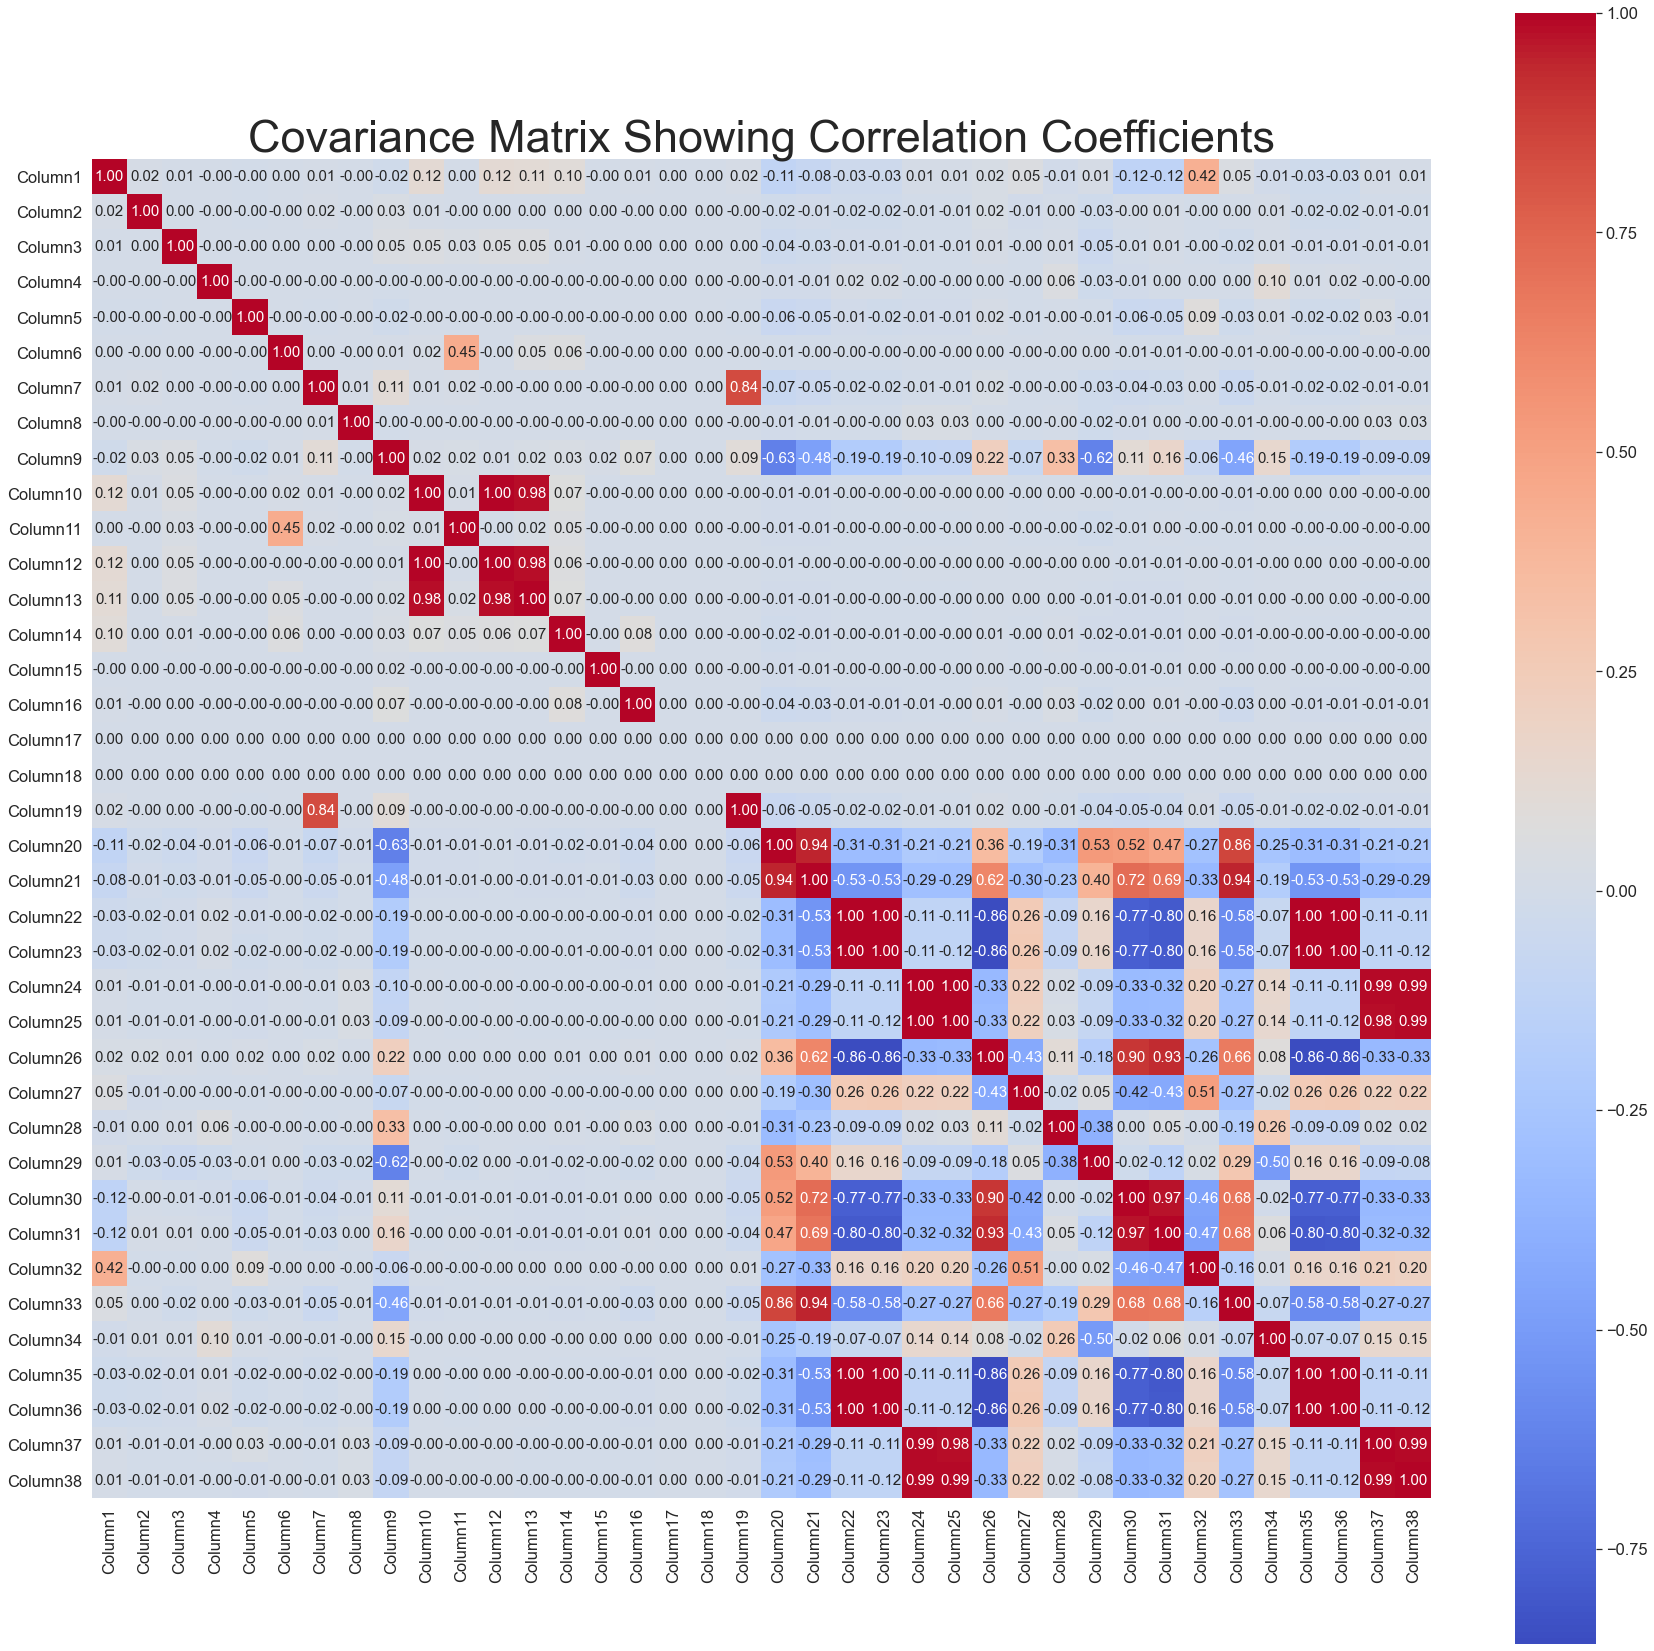

In [8]:
cols = ['Column1', 'Column2', 'Column3', 'Column4', 'Column5','Column6','Column7','Column8','Column9','Column10','Column11','Column12','Column13','Column14','Column15','Column16','Column17','Column18','Column19','Column20','Column21','Column22','Column23','Column24','Column25','Column26','Column27','Column28','Column29','Column30','Column31','Column32','Column33','Column34','Column35','Column36','Column37','Column38']

stdsc = StandardScaler() 
X_std = stdsc.fit_transform(X_sample[cols].iloc[:,range(0,38)].values)
cov_mat =np.cov(X_std.T)
plt.figure(figsize=(30,30))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 cmap='coolwarm',                 
                 yticklabels=cols,
                 xticklabels=cols)
plt.title('Covariance Matrix Showing Correlation Coefficients', size = 45)
# plt.tight_layout()
plt.show()

# code snippet from https://medium.com/towards-artificial-intelligence/feature-selection-and-dimensionality-reduction-using-covariance-matrix-plot-b4c7498abd07

## First, it is important to choose a threshold for the correlation coefficient - let's say that any features that have a correlation coefficient of .7 or greater are considered to be strongly related. We want to remove features that have strong correlation to avoid redundancy. 

To do this, we will first determine which features are related to one another and put them into 'buckets' representing this relationship. The correlated features have been sorted into the following:

- 7, 19
- 10, 12, 13
- 20, 21, 30, 33
- 24, 25, 37, 38
- 22, 23, 26, 30, 31, 35, 36

Now, to reduce the number of features and avoid having features that tell us the same information, one feature from each bucket will be selected to represent the other features in that bucket. So, from the correlated buckets the following features were randomly selected:

- 7
- 13
- 20
- 38
- 35

Therefore, we may now conduct experiments with LOF using various values for number of nearest neighbors and can see how the number of selected features impacts the results. We can now convert the dataframe back into a numpy array since we have gathered the information we need. 

In [9]:
X_sample = X_sample.to_numpy()
type(X_sample)
print(X_sample.shape)

(59000, 38)


We can begin by running the LOF algorithm using the full 38 numerical features. In addition, we can see how the Isolation Forest algorithm does with all features. 

In [10]:
recall_scores_lof = []
precision_scores_lof = []
f1_scores_lof = []
weighted_f1_scores_lof = []
false_alarms_lof = []


def lof_calculations(n):    
    
    lof = LocalOutlierFactor(n_neighbors = n)
    y_pred = lof.fit_predict(X_sample)
    y_pred = np.array(y_pred)
    
    r = recall_score(y_sample, y_pred, pos_label = -1)
    p = precision_score(y_sample, y_pred, pos_label = -1)
    f = f1_score(y_sample, y_pred, pos_label = -1)
    wf = f1_score(y_sample, y_pred, average = 'weighted')
    
    tn, fp, fn, tp = confusion_matrix(y_sample,y_pred).ravel()
    false_alarm = fp/(fp+tn)
   
    recall_scores_lof.append(r)
    precision_scores_lof.append(p)
    f1_scores_lof.append(f)
    weighted_f1_scores_lof.append(wf)
    false_alarms_lof.append(false_alarm)

In [11]:
# Remove feature 19
X_sample2 = np.delete(X_sample,[18],1)
X_sample2.shape

(59000, 37)

In [12]:
recall_scores_lof2 = []
precision_scores_lof2 = []
f1_scores_lof2 = []
weighted_f1_scores_lof2 = []
false_alarms_lof2 = []


def lof_calculations2(n):    
    
    lof = LocalOutlierFactor(n_neighbors = n)
    y_pred = lof.fit_predict(X_sample2)
    y_pred = np.array(y_pred)
    
    r = recall_score(y_sample, y_pred, pos_label = -1)
    p = precision_score(y_sample, y_pred, pos_label = -1)
    f = f1_score(y_sample, y_pred, pos_label = -1)
    wf = f1_score(y_sample, y_pred, average = 'weighted')
    
    tn, fp, fn, tp = confusion_matrix(y_sample,y_pred).ravel()
    false_alarm = fp/(fp+tn)
   
    recall_scores_lof2.append(r)
    precision_scores_lof2.append(p)
    f1_scores_lof2.append(f)
    weighted_f1_scores_lof2.append(wf)
    false_alarms_lof2.append(false_alarm)

In [13]:
# Remove features 10, 12
X_sample3 = np.delete(X_sample,[9,11,18],1)
X_sample3.shape

(59000, 35)

In [14]:
recall_scores_lof3 = []
precision_scores_lof3 = []
f1_scores_lof3 = []
weighted_f1_scores_lof3 = []
false_alarms_lof3 = []


def lof_calculations3(n):    
    
    lof = LocalOutlierFactor(n_neighbors = n)
    y_pred = lof.fit_predict(X_sample3)
    y_pred = np.array(y_pred)
    
    r = recall_score(y_sample, y_pred, pos_label = -1)
    p = precision_score(y_sample, y_pred, pos_label = -1)
    f = f1_score(y_sample, y_pred, pos_label = -1)
    wf = f1_score(y_sample, y_pred, average = 'weighted')
    
    tn, fp, fn, tp = confusion_matrix(y_sample,y_pred).ravel()
    false_alarm = fp/(fp+tn)
   
    recall_scores_lof3.append(r)
    precision_scores_lof3.append(p)
    f1_scores_lof3.append(f)
    weighted_f1_scores_lof3.append(wf)
    false_alarms_lof3.append(false_alarm)

In [15]:
# Remove features 21, 30, 33
X_sample4 = np.delete(X_sample,[9,11,18,20,29,32],1)
X_sample4.shape

(59000, 32)

In [16]:
recall_scores_lof4 = []
precision_scores_lof4 = []
f1_scores_lof4 = []
weighted_f1_scores_lof4 = []
false_alarms_lof4 = []


def lof_calculations4(n):    
    
    lof = LocalOutlierFactor(n_neighbors = n)
    y_pred = lof.fit_predict(X_sample4)
    y_pred = np.array(y_pred)
    
    r = recall_score(y_sample, y_pred, pos_label = -1)
    p = precision_score(y_sample, y_pred, pos_label = -1)
    f = f1_score(y_sample, y_pred, pos_label = -1)
    wf = f1_score(y_sample, y_pred, average = 'weighted')
    
    tn, fp, fn, tp = confusion_matrix(y_sample,y_pred).ravel()
    false_alarm = fp/(fp+tn)
   
    recall_scores_lof4.append(r)
    precision_scores_lof4.append(p)
    f1_scores_lof4.append(f)
    weighted_f1_scores_lof4.append(wf)
    false_alarms_lof4.append(false_alarm)

In [17]:
# Remove features 24, 25, 37
X_sample5 = np.delete(X_sample,[9,11,18,20,29,32,23,24,36],1)
X_sample5.shape

(59000, 29)

In [18]:
recall_scores_lof5 = []
precision_scores_lof5 = []
f1_scores_lof5 = []
weighted_f1_scores_lof5 = []
false_alarms_lof5 = []


def lof_calculations5(n):    
    
    lof = LocalOutlierFactor(n_neighbors = n)
    y_pred = lof.fit_predict(X_sample5)
    y_pred = np.array(y_pred)
    
    r = recall_score(y_sample, y_pred, pos_label = -1)
    p = precision_score(y_sample, y_pred, pos_label = -1)
    f = f1_score(y_sample, y_pred, pos_label = -1)
    wf = f1_score(y_sample, y_pred, average = 'weighted')
    
    tn, fp, fn, tp = confusion_matrix(y_sample,y_pred).ravel()
    false_alarm = fp/(fp+tn)
   
    recall_scores_lof5.append(r)
    precision_scores_lof5.append(p)
    f1_scores_lof5.append(f)
    weighted_f1_scores_lof5.append(wf)
    false_alarms_lof5.append(false_alarm)

In [19]:
# Remove features 22, 23, 26, 31, 36
X_sample6 = np.delete(X_sample,[9,11,18,20,29,32,23,24,36,21,22,25,30,35],1)
X_sample6.shape

(59000, 24)

In [20]:
recall_scores_lof6 = []
precision_scores_lof6 = []
f1_scores_lof6 = []
weighted_f1_scores_lof6 = []
false_alarms_lof6 = []


def lof_calculations6(n):    
    
    lof = LocalOutlierFactor(n_neighbors = n)
    y_pred = lof.fit_predict(X_sample)
    y_pred = np.array(y_pred)
    
    r = recall_score(y_sample, y_pred, pos_label = -1)
    p = precision_score(y_sample, y_pred, pos_label = -1)
    f = f1_score(y_sample, y_pred, pos_label = -1)
    wf = f1_score(y_sample, y_pred, average = 'weighted')
    
    tn, fp, fn, tp = confusion_matrix(y_sample,y_pred).ravel()
    false_alarm = fp/(fp+tn)
   
    recall_scores_lof6.append(r)
    precision_scores_lof6.append(p)
    f1_scores_lof6.append(f)
    weighted_f1_scores_lof6.append(wf)
    false_alarms_lof6.append(false_alarm)

In [21]:
recall_scores_isof = []
precision_scores_isof = []
f1_scores_isof = []
weighted_f1_scores_isof = []
false_alarms_isof = []

def isof_calculations(n):
    
    isof = IsolationForest(max_samples=n, random_state=42)
    y_pred = isof.fit_predict(X_sample)
    y_pred = np.array(y_pred)
    
    p = precision_score(y_sample, y_pred, pos_label = -1)
    r = recall_score(y_sample, y_pred, pos_label = -1)
    f = f1_score(y_sample, y_pred, pos_label = -1)
    wf = f1_score(y_sample, y_pred, average = 'weighted')
    
    tn, fp, fn, tp = confusion_matrix(y_sample,y_pred).ravel()
    false_alarm = fp/(fp+tn) 
    
    recall_scores_isof.append(r)
    precision_scores_isof.append(p)
    f1_scores_isof.append(f)
    weighted_f1_scores_isof.append(wf)
    false_alarms_isof.append(false_alarm)

In [22]:
ilist = []
i = 1
while i<5:
    lof_calculations(i)
    lof_calculations2(i)
    lof_calculations3(i)
    lof_calculations4(i)
    lof_calculations5(i)
    lof_calculations6(i)
    isof_calculations(i)
    ilist.append(i)
    i=i+1
    
i = 5
while i <= 160:
    lof_calculations(i)
    lof_calculations2(i)
    lof_calculations3(i)
    lof_calculations4(i)
    lof_calculations5(i)
    lof_calculations6(i)
    isof_calculations(i)
    ilist.append(i)
    i = i*2

c:\users\kajia\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\ensemble\_iforest.py:473: RuntimeWarning: invalid value encountered in true_divide
  -depths
c:\users\kajia\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\ensemble\_iforest.py:336: RuntimeWarning: invalid value encountered in less
  is_inlier[self.decision_function(X) < 0] = -1
c:\users\kajia\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kajia\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

-------------------------------------------------------------------------------------------------------------------------------

## No Feature Selection - LOF and Isolation Forest

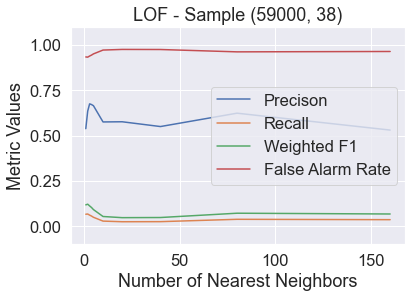

In [23]:
plt.plot(ilist, precision_scores_lof, label='Precison')
plt.plot(ilist, recall_scores_lof, label='Recall')
plt.plot(ilist, f1_scores_lof,label='Weighted F1')
plt.plot(ilist, false_alarms_lof, label = 'False Alarm Rate')
    
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Metric Values')
plt.title('LOF - Sample (59000, 38)')
    
leg = plt.legend();

plt.ylim((-.1, 1.1))

plt.show()

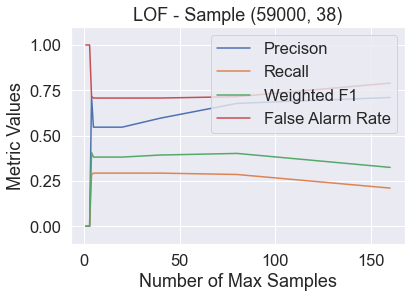

In [24]:
plt.plot(ilist, precision_scores_isof, label='Precison')
plt.plot(ilist, recall_scores_isof, label='Recall')
plt.plot(ilist, f1_scores_isof,label='Weighted F1')
plt.plot(ilist, false_alarms_isof, label = 'False Alarm Rate')
    
plt.xlabel('Number of Max Samples')
plt.ylabel('Metric Values')
plt.title('LOF - Sample (59000, 38)')
    
leg = plt.legend();

plt.ylim((-.1, 1.1))

plt.show()

-------------------------------------------------------------------------------------------------------------------------------

## Plots By Metric

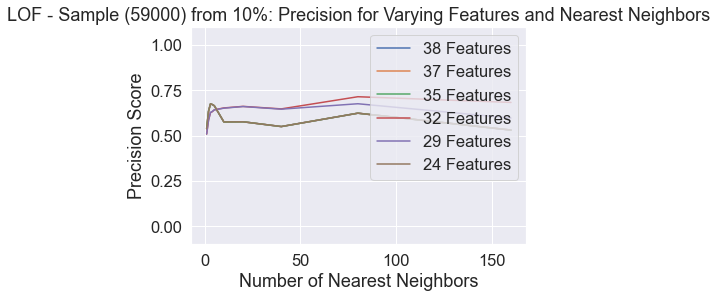

In [35]:
plt.plot(ilist, precision_scores_lof, label='38 Features')
plt.plot(ilist, precision_scores_lof2, label='37 Features')
plt.plot(ilist, precision_scores_lof3, label='35 Features')
plt.plot(ilist, precision_scores_lof4, label='32 Features')
plt.plot(ilist, precision_scores_lof5, label='29 Features')
plt.plot(ilist, precision_scores_lof6, label='24 Features')

plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Precision Score')
plt.title('LOF - Sample (59000) from 10%: Precision for Varying Features and Nearest Neighbors')


plt.ylim((-.1, 1.1))
leg = plt.legend();

plt.show()

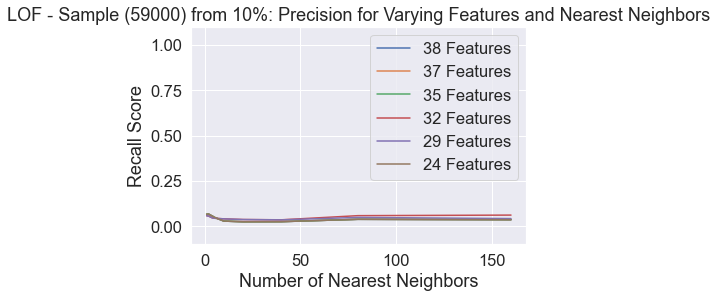

In [36]:
plt.plot(ilist, recall_scores_lof, label='38 Features')
plt.plot(ilist, recall_scores_lof2, label='37 Features')
plt.plot(ilist, recall_scores_lof3, label='35 Features')
plt.plot(ilist, recall_scores_lof4, label='32 Features')
plt.plot(ilist, recall_scores_lof5, label='29 Features')
plt.plot(ilist, recall_scores_lof6, label='24 Features')

plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Recall Score')
plt.title('LOF - Sample (59000) from 10%: Precision for Varying Features and Nearest Neighbors')


plt.ylim((-.1, 1.1))
leg = plt.legend();

plt.show()

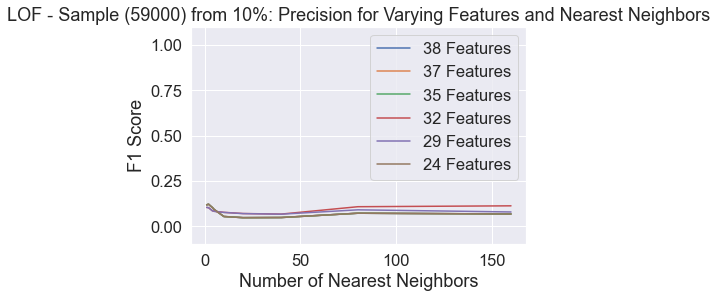

In [37]:
plt.plot(ilist, f1_scores_lof, label='38 Features')
plt.plot(ilist, f1_scores_lof2, label='37 Features')
plt.plot(ilist, f1_scores_lof3, label='35 Features')
plt.plot(ilist, f1_scores_lof4, label='32 Features')
plt.plot(ilist, f1_scores_lof5, label='29 Features')
plt.plot(ilist, f1_scores_lof6, label='24 Features')

plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('F1 Score')
plt.title('LOF - Sample (59000) from 10%: Precision for Varying Features and Nearest Neighbors')


plt.ylim((-.1, 1.1))
leg = plt.legend();

plt.show()

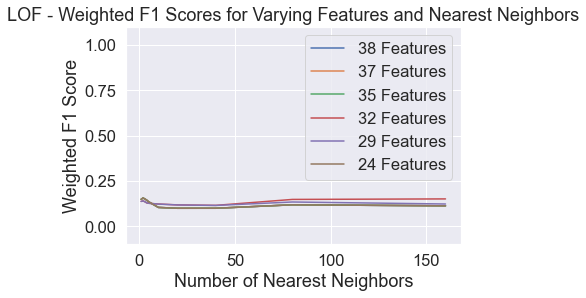

In [38]:
plt.plot(ilist, weighted_f1_scores_lof, label='38 Features')
plt.plot(ilist, weighted_f1_scores_lof2, label='37 Features')
plt.plot(ilist, weighted_f1_scores_lof3, label='35 Features')
plt.plot(ilist, weighted_f1_scores_lof4, label='32 Features')
plt.plot(ilist, weighted_f1_scores_lof5, label='29 Features')
plt.plot(ilist, weighted_f1_scores_lof6, label='24 Features')

plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Weighted F1 Score')
plt.title('LOF - Weighted F1 Scores for Varying Features and Nearest Neighbors')
# plt.title('Sample (59000) from 10%')


plt.ylim((-.1, 1.1))
leg = plt.legend();

plt.show()

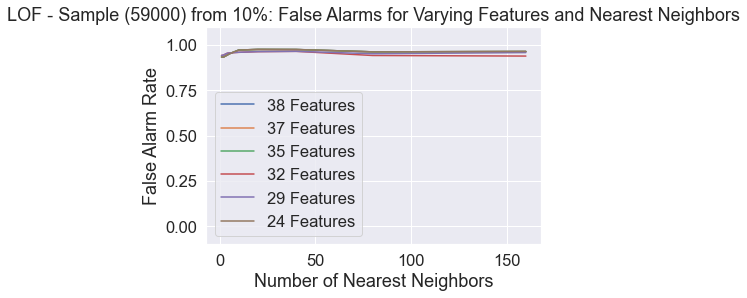

In [39]:
plt.plot(ilist, false_alarms_lof, label='38 Features')
plt.plot(ilist, false_alarms_lof2, label='37 Features')
plt.plot(ilist, false_alarms_lof3, label='35 Features')
plt.plot(ilist, false_alarms_lof4, label='32 Features')
plt.plot(ilist, false_alarms_lof5, label='29 Features')
plt.plot(ilist, false_alarms_lof6, label='24 Features')

plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('False Alarm Rate')
plt.title('LOF - Sample (59000) from 10%: False Alarms for Varying Features and Nearest Neighbors')


plt.ylim((-.1, 1.1))
leg = plt.legend();

plt.show()

-------------------------------------------------------------------------------------------------------------------------------

## Plots By Number of Features

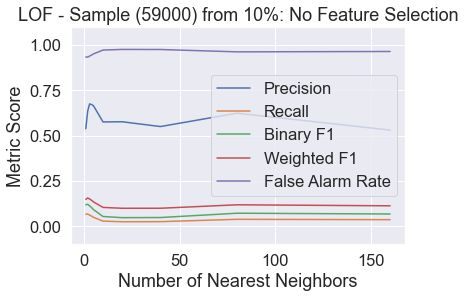

In [41]:
plt.plot(ilist, precision_scores_lof, label='Precision')
plt.plot(ilist, recall_scores_lof, label='Recall')
plt.plot(ilist, f1_scores_lof, label='Binary F1')
plt.plot(ilist, weighted_f1_scores_lof, label='Weighted F1')
plt.plot(ilist, false_alarms_lof, label='False Alarm Rate')

plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Metric Score')
plt.title('LOF - Sample (59000) from 10%: No Feature Selection')


plt.ylim((-.1, 1.1))
leg = plt.legend();

plt.show()

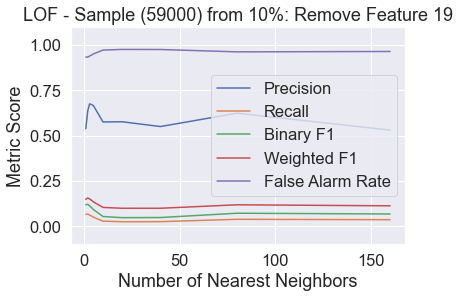

In [42]:
plt.plot(ilist, precision_scores_lof2, label='Precision')
plt.plot(ilist, recall_scores_lof2, label='Recall')
plt.plot(ilist, f1_scores_lof2, label='Binary F1')
plt.plot(ilist, weighted_f1_scores_lof2, label='Weighted F1')
plt.plot(ilist, false_alarms_lof2, label='False Alarm Rate')

plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Metric Score')
plt.title('LOF - Sample (59000) from 10%: Remove Feature 19')


plt.ylim((-.1, 1.1))
leg = plt.legend();

plt.show()

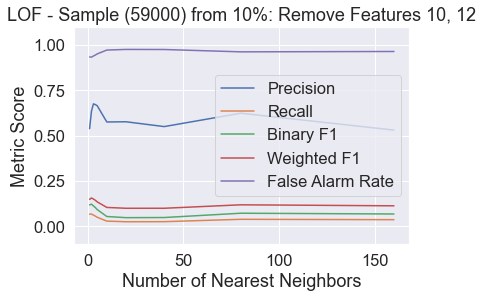

In [43]:
plt.plot(ilist, precision_scores_lof3, label='Precision')
plt.plot(ilist, recall_scores_lof3, label='Recall')
plt.plot(ilist, f1_scores_lof3, label='Binary F1')
plt.plot(ilist, weighted_f1_scores_lof3, label='Weighted F1')
plt.plot(ilist, false_alarms_lof3, label='False Alarm Rate')

plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Metric Score')
plt.title('LOF - Sample (59000) from 10%: Remove Features 10, 12')


plt.ylim((-.1, 1.1))
leg = plt.legend();

plt.show()

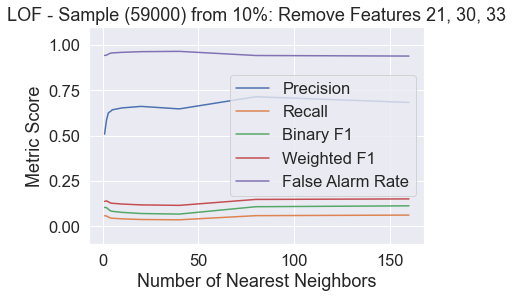

In [47]:
plt.plot(ilist, precision_scores_lof4, label='Precision')
plt.plot(ilist, recall_scores_lof4, label='Recall')
plt.plot(ilist, f1_scores_lof4, label='Binary F1')
plt.plot(ilist, weighted_f1_scores_lof4, label='Weighted F1')
plt.plot(ilist, false_alarms_lof4, label='False Alarm Rate')

plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Metric Score')
plt.title('LOF - Sample (59000) from 10%: Remove Features 21, 30, 33')


plt.ylim((-.1, 1.1))
leg = plt.legend();

plt.show()

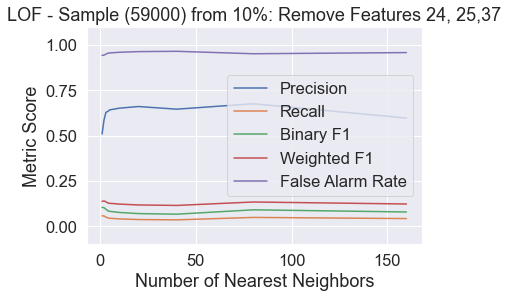

In [45]:
plt.plot(ilist, precision_scores_lof5, label='Precision')
plt.plot(ilist, recall_scores_lof5, label='Recall')
plt.plot(ilist, f1_scores_lof5, label='Binary F1')
plt.plot(ilist, weighted_f1_scores_lof5, label='Weighted F1')
plt.plot(ilist, false_alarms_lof5, label='False Alarm Rate')

plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Metric Score')
plt.title('LOF - Sample (59000) from 10%: Remove Features 24, 25,37')


plt.ylim((-.1, 1.1))
leg = plt.legend();

plt.show()

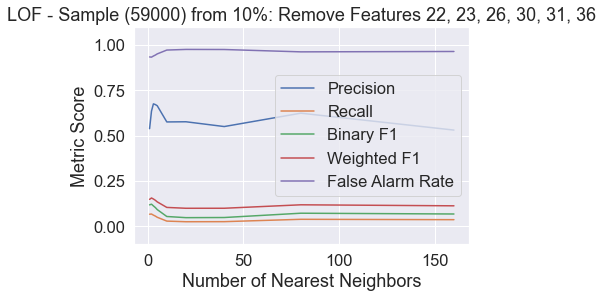

In [46]:
plt.plot(ilist, precision_scores_lof6, label='Precision')
plt.plot(ilist, recall_scores_lof6, label='Recall')
plt.plot(ilist, f1_scores_lof6, label='Binary F1')
plt.plot(ilist, weighted_f1_scores_lof6, label='Weighted F1')
plt.plot(ilist, false_alarms_lof6, label='False Alarm Rate')

plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Metric Score')
plt.title('LOF - Sample (59000) from 10%: Remove Features 22, 23, 26, 30, 31, 36')


plt.ylim((-.1, 1.1))
leg = plt.legend();

plt.show()

-------------------------------------------------------------------------------------------------------------------------------